In [1]:
import pandas as pd
import numpy as np
import os
from os import path
import shutil
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import re
import traceback
%matplotlib inline

In [2]:
# focus on three regions now
regions = [
    "Burgenland",
    "Kärnten",
    "Niederösterreich",
    "Oberösterreich",
    "Salzburg",
    "Steiermark",
    "Tirol",
    "Vorarlberg",
    "Wien"
]
region_dirs = ["/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_{}_gw_{}".format(num, regions[idx]) for idx, num in enumerate(range(1, len(regions)+1))]
region_dirs

['/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_1_gw_Burgenland',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_2_gw_Kärnten',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_3_gw_Niederösterreich',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_4_gw_Oberösterreich',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_5_gw_Salzburg',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_6_gw_Steiermark',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_7_gw_Tirol',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_8_gw_Vorarlberg',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_9_gw_Wien']

## Measuring point data with regions

In [3]:
def get_num_from_str(string):
    matches = re.findall(r"\d+\.\d+", string)
    if len(matches):
        return matches[0]
    else:
        return np.nan

def get_mp_attrs(region, region_dir, mp_num):

    mp_base_data_path = path.join(region_dir, "Stammdaten", "Stammdaten-{0}.txt".format(mp_num))
    
    land_height = np.nan
    mp_height = np.nan
    bottom_line = np.nan
    t_measuring_depth = np.nan
    
    with open(mp_base_data_path, encoding='unicode_escape') as f:
        for num, line in enumerate(f, 1):
            if "Geländehöhe" in line:
                land_height = get_num_from_str(line)
                
            elif "Messpunkthöhe" in line:
                mp_height = get_num_from_str(line)
                
            elif "Sohllage" in line:
                bottom_line = get_num_from_str(line)
                
            elif "T-Messtiefe u.GOK" in line:
                t_measuring_depth = get_num_from_str(line)
                
                break # since it's always listed latest in the file
    
    mp = {
        "land_height": land_height,
        "mp_height": mp_height,
        "bottom_line": bottom_line,
        "t_measuring_depth": t_measuring_depth
    }
    
    return mp


# test
region_idx = 0

# try mp with full attr
mp_num = 305540
mp_attrs = get_mp_attrs(regions[region_idx], region_dirs[region_idx], mp_num = mp_num)
print("mp {0} attrs:".format(mp_num), mp_attrs)

# try mp with missing attr -> np.nan in missed value
mp_num = 300137
mp_attrs = get_mp_attrs(regions[region_idx], region_dirs[region_idx], mp_num = mp_num)
print("mp {0} attrs:".format(mp_num), mp_attrs)

mp 305540 attrs: {'land_height': '120.68', 'mp_height': '120.88', 'bottom_line': '114.98', 't_measuring_depth': '5.60'}
mp 300137 attrs: {'land_height': '154.76', 'mp_height': '154.76', 'bottom_line': '151.36', 't_measuring_depth': nan}


In [4]:
values = []

for i in range(len(regions)):
    region = regions[i]
    region_dir = region_dirs[i]
    # mps: measurment points 
    df_mps_path = path.join(region_dir, "messstellen_alle.csv")
    df_mps = pd.read_csv(df_mps_path, sep=";")
    # filter to typ == 'gw' then del typ col
    df_mps = df_mps.query("typ=='gw'")
    del df_mps["typ"]
    
    df_mps["region"] = region
    
    # for every mp in the region get attributes
    # create attrs cols and init with np.nan
    mp_attrs = ["land_height", "mp_height", "bottom_line", "t_measuring_depth"]
    for mp_attr in mp_attrs:
        df_mps[mp_attr] = np.nan
    
    # fill with values when available
    for index, row in df_mps.iterrows():
        mp_num = row["hzbnr01"]
        mp_attr_vals = get_mp_attrs(region, region_dir, mp_num = mp_num)
        for mp_attr in mp_attrs:
            df_mps.at[index, mp_attr] = float(mp_attr_vals[mp_attr])
    
    values.extend(df_mps.values.tolist())

colnames = ["x", "y", "dbmsnr", "hzbnr01", "region"] + mp_attrs
df_mps_all = pd.DataFrame(values, columns = colnames)
df_mps_all["x"] = df_mps_all["x"].str.replace(",", ".").astype(float)
df_mps_all["y"] = df_mps_all["y"].str.replace(",", ".").astype(float)

df_mps_all

,x,y,dbmsnr,hzbnr01,region,land_height,mp_height,bottom_line,t_measuring_depth
0,679020.30,448967.00,1002266,335588,Burgenland,125.76,126.66,108.29,NaN
1,643311.78,398158.79,1002285,335810,Burgenland,235.69,236.59,225.74,10.00
2,616039.28,341145.21,1002422,345876,Burgenland,234.06,234.86,228.06,NaN
3,615420.17,341879.22,1002237,335299,Burgenland,238.18,238.28,233.38,NaN
4,665124.60,430698.99,1002327,345256,Burgenland,116.99,117.54,114.65,NaN
...,...,...,...,...,...,...,...,...,...
3786,631609.35,485861.88,9002133,319749,Wien,157.12,157.07,142.07,NaN
3787,622685.15,480101.35,9002268,350074,Wien,187.09,187.94,175.89,NaN
3788,633723.06,481067.86,9002260,350116,Wien,160.93,161.93,150.93,NaN
3789,633459.50,482115.68,9002231,341438,Wien,154.76,155.71,145.15,6.05


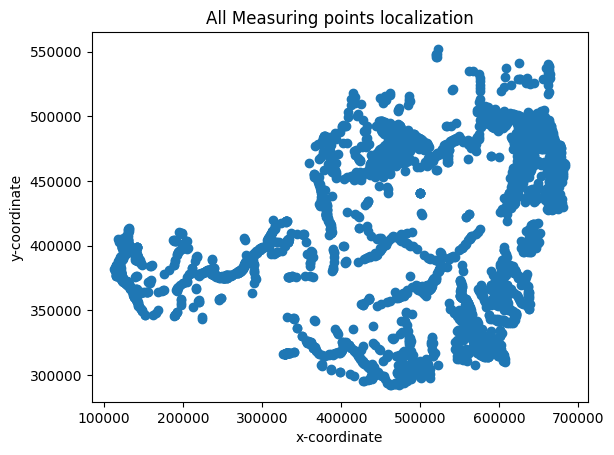

In [5]:
plt.scatter(df_mps_all["x"], df_mps_all["y"])
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("All Measuring points localization")
plt.show()

In [6]:
sub_path = "/users/azeez/water_prediction/ai4ls_2_water_prediction/data/processed/gw_test_empty.csv"
submission_df = pd.read_csv(sub_path)
test_ids = submission_df.columns[1:]

In [7]:
# define radius for measuring point within neighbouring temperature points

def find_temp_mps_in_radius(region, df_mps_all, temp_mps, hzbnr01, radius):

    # get region df
    # df_mps_all = df_mps_all[df_mps_all["region"]==region]

    # get mp coordiantes
    c_x = df_mps_all.query('hzbnr01==@hzbnr01').iloc[0]["x"]
    c_y = df_mps_all.query('hzbnr01==@hzbnr01').iloc[0]["y"]

    # find all mps in radius
    x_min = c_x - radius
    x_max = c_x + radius
    y_min = c_y - radius
    y_max = c_y + radius
    df_mps_rds = df_mps_all.query('(@x_min <= x <= @x_max) & (@y_min <= y <= @y_max)')
    
    # get the temp mps in the radius dataframe
    df_temp = df_mps_rds[df_mps_rds["hzbnr01"].isin(temp_mps)]
    
    return df_temp["hzbnr01"].tolist()


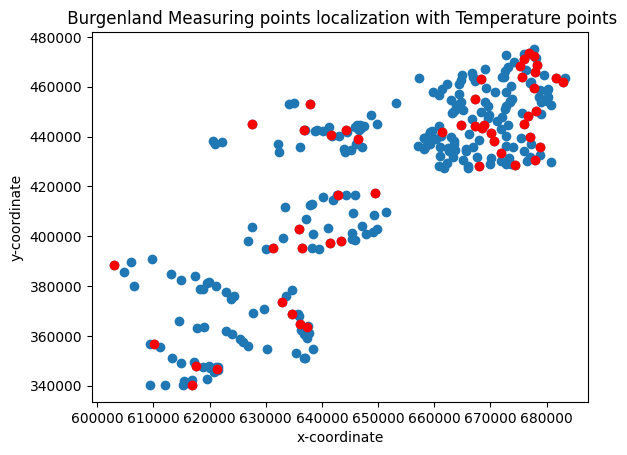

In [8]:
# Get all the groundwater temperature hzhnr01
burg = df_mps_all[df_mps_all["region"]=="Burgenland"]

burg_temp_dir = region_dirs[0] + "/Grundwassertemperatur-Monatsmittel" 
filenames = os.listdir(burg_temp_dir)
mps = []
for file in filenames:
    loc_id = file.split(".")[0].split("-")[-1]
    mps.append(int(loc_id)) 
burg_temp_df = burg[burg["hzbnr01"].isin(mps)]

# Plot the temperature points areas with the groundwater locations in Burgenland
plt.scatter(burg["x"], burg["y"])
plt.scatter(burg_temp_df["x"], burg_temp_df["y"], color="r")
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title(" Burgenland Measuring points localization with Temperature points")
plt.show()